In [39]:
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, lrna_price, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.10},
    'R1': {'usd price': 1, 'weight': 0.10},
    'R2': {'usd price': 2/3, 'weight': 0.70},
}

lrna_price_usd = 1
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

time_steps = 1000
pump_factor = 5
for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=0.0005,
            asset_fee=0.0025
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={tkn: 10000000000 for tkn in list(assets.keys()) + ['LRNA']},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3
            )
        ),
        'LP': Agent(
            holdings={'R1': 1000000},
            trade_strategy=invest_all(
                pool_id='omnipool',
                when=int(time_steps/2)
            )
        )
    },
    evolve_function=historical_prices(price_list=[
        {'R1': pump_factor - (abs(i * 2 - time_steps) / time_steps * (pump_factor - 1))} for i in range(time_steps + 1)
    ]),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)
events = run.run(initial_state, time_steps=time_steps)

# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Starting simulation...
Execution time: 1.981 seconds.


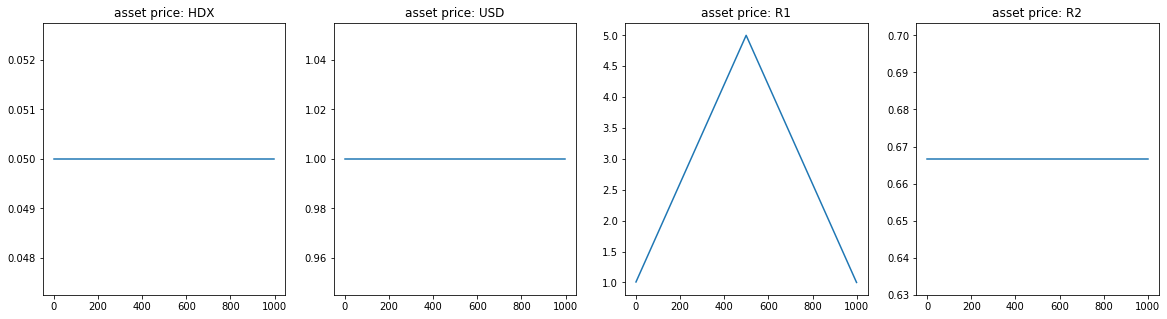

In [40]:
pu.plot(events, asset='all')

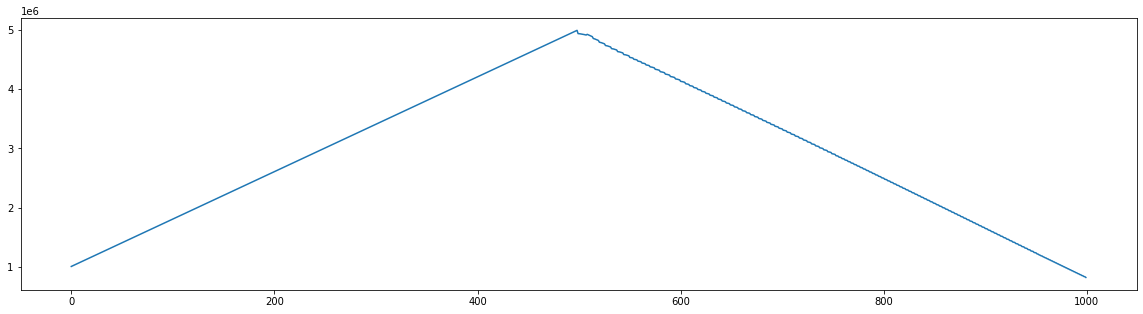

In [41]:
plt.figure(figsize=(20, 5))
plt.plot(
    range(time_steps), 
    [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events]
)

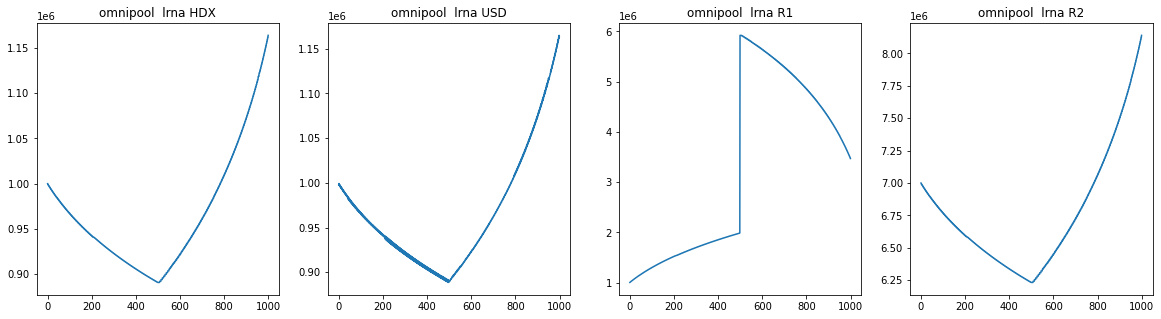

In [42]:
pu.plot(events, pool='omnipool', prop='lrna')

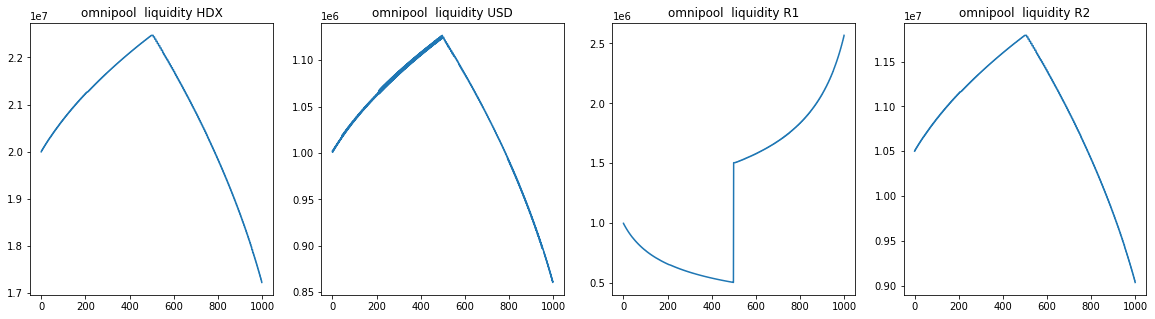

In [51]:
pu.plot(events, pool='omnipool', prop='liquidity')

In [52]:
# pu.plot(events, agent='Arbitrageur', prop='holdings')

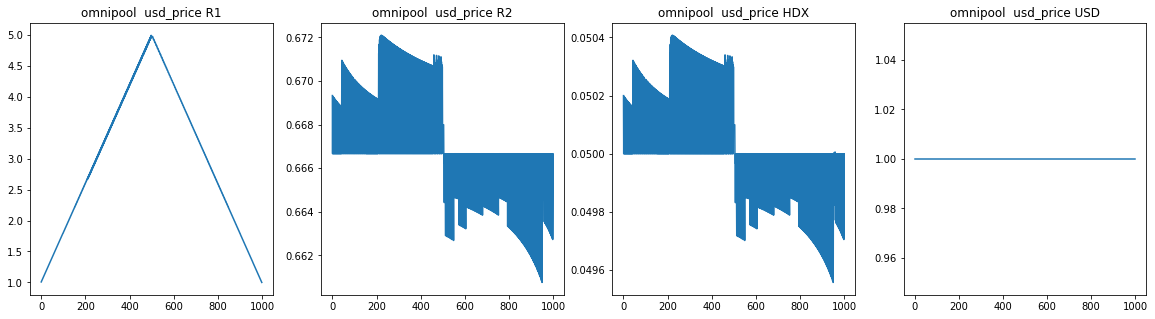

In [53]:
pu.plot(events, pool='omnipool', prop='usd_price', key=['R1', 'R2', 'HDX', 'USD'])

In [54]:
cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market)

822472.3735195408

In [55]:
cash_out_omnipool(events[0].pools['omnipool'], events[0].agents['LP'], events[0].external_market)

1008000.0

<AxesSubplot:title={'center':'omnipool  lrna_price USD '}>

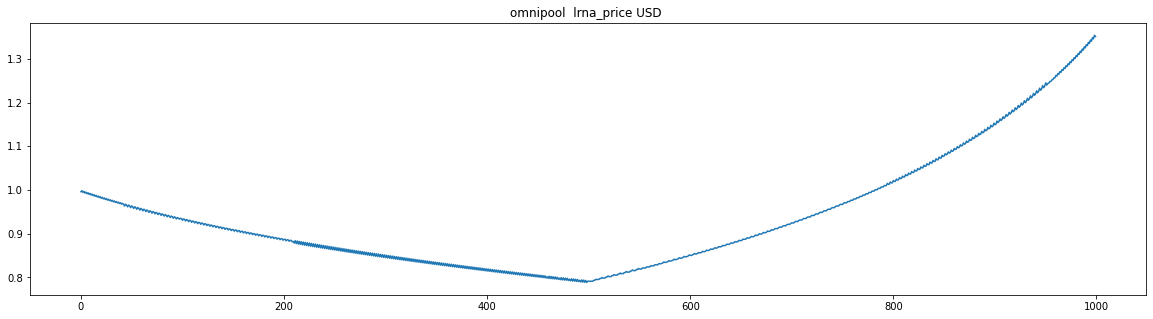

In [56]:
pu.plot(events, pool='omnipool', prop='lrna_price', key='USD')

In [57]:
print(lrna_price(events[0].pools['omnipool'], 'USD'), lrna_price(events[-1].pools['omnipool'], 'USD'))

0.9960178996027085 1.351094501321784


In [50]:
print(events[999].agents['LP'].holdings)

{'R1': 0, 'LRNA': 0, 'R2': 0, 'USD': 0, 'HDX': 0, ('omnipool', 'R1'): 1982352.5127837728, ('omnipool', 'R2'): 0.0, ('omnipool', 'USD'): 0.0, ('omnipool', 'HDX'): 0.0}


In [27]:
print(events[999].time_step)

1000


In [14]:
print(time_steps / 2)

500.0
